In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install fastai kaggle transformers timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 50.4 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73031 sha256=e2b678ac9d7c2cfa9adc205324f86b78554eb88c468369340d69140be24d0615
  Stored in directory: /root/.cache/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle


In [2]:
from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification
from jupyter_helpers import *
from helpers import *

set_seed(99, True)

In [3]:
bs = 128
convnext_arch = "facebook/convnext-tiny-224"
# convnext_arch = "facebook/convnext-base-224"

levit_arch = "levit_256"
# levit_arch = "levit_384"

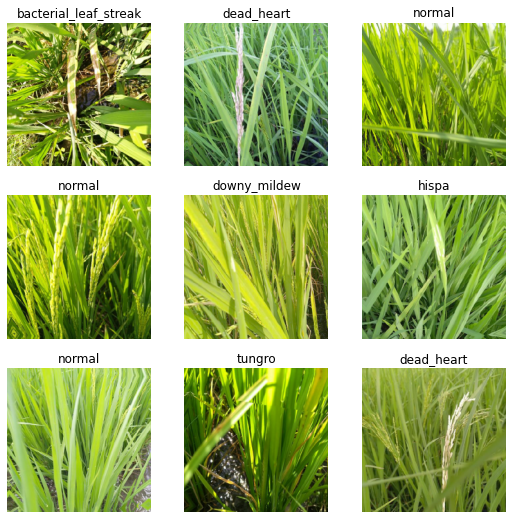

In [4]:
dls = get_image_dls(bs)
dls.show_batch()

In [5]:
create_convnext_with_classes = partial(create_convnext, num_classes=len(dls.vocab))

# Get Hugging Face Vision Models

In [6]:
extract_features = get_convnext_feature_extractor(convnext_arch)

In [7]:
class MyHFImageModel1(Module):
    def __init__(self, with_relu: bool = False):
        self.with_relu = with_relu
        self.model = create_convnext_with_classes(convnext_arch, with_relu=with_relu)
        
        # Debugging Params
        self.convnext_arch = convnext_arch
    
    def forward(self, x):
        x = extract_features(x)
        x = self.model(x).logits
        return x
    
def hf_splitter1(model):
    return (params(model.model.convnext), params(model.model.classifier))

In [ ]:
with safely_train_with_gpu():
    train_learner(dls, MyHFImageModel1(with_relu=False), hf_splitter1)

epoch,train_loss,valid_loss,accuracy,time
0,1.583349,1.396613,0.544930,01:37
1,1.266903,1.254573,0.592023,01:37


epoch,train_loss,valid_loss,accuracy,time
0,0.702835,0.642544,0.778952,02:05
1,0.474059,0.452148,0.854877,01:59
2,0.263986,0.202551,0.938011,01:58
3,0.109956,0.122568,0.966362,01:58
4,0.053850,0.097378,0.971168,01:57


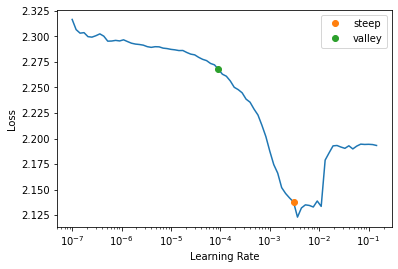

In [10]:
with safely_train_with_gpu():
    train_learner(dls, MyHFImageModel1(with_relu=True), hf_splitter1)

# Ensembled Model

In [14]:
def train_with_relu(model_class, splitter):
    for with_relu in (False, True):
        with safely_train_with_gpu():
            learn = train_learner(dls, model_class(with_relu=with_relu), splitter, lr_multiplier=1.0)
            print('with_relu =', with_relu)
            print('Convnext:', learn.convnext_arch)
            print('Model Weight:', learn.model_weights[0].detach().cpu().numpy().tolist())
            print()
            print('Levit:', learn.levit_arch)
            print('Model Weight:', learn.model_weights[1].detach().cpu().numpy().tolist())
            print()
            if len(learn.model_weights) == 3:
                print('Divisor:', learn.model_weights[2].detach().cpu().numpy().tolist())
                print()

In [8]:
# Here we use a single number to weight each models output.

class MyHFImageModel2(Module):
    def __init__(self, with_relu: bool = False):
        self.model_weights = nn.Parameter(tensor([0.5, 0.5]), requires_grad=True)
        self.model1 = create_convnext_with_classes(convnext_arch, with_relu=with_relu)
        self.model2 = vision_learner(dls, levit_arch).model
        
        # Parameter references to be used by model splitter
        self.model1_body = self.model1.convnext
        self.model1_head = self.model1.classifier
        
        self.model2_body = self.model2[0]
        self.model2_head = self.model2[1]
        
        # Debugging Params
        self.convnext_arch = convnext_arch
        self.levit_arch = levit_arch
    
    def forward(self, x):
        x1 = self.model1(extract_features(x)).logits
        x2 = self.model2(x)
        
        weight1 = self.model_weights[0]
        weight2 = self.model_weights[1]
        
        return x1 * weight1 + x2 * weight2
    
def hf_splitter2(m):
    return (params(m.model1_body) + params(m.model2_body), 
            params(m.model1_head) + params(m.model2_head) + [m.model_weights])

def hf_splitter3(m):
    return (params(m.model1_body) + params(m.model2_body), 
            [m.model_weights],
            params(m.model1_head) + params(m.model2_head))

def hf_splitter4(m):
    return (params(m.model1_body) + params(m.model2_body) + [m.model_weights],
            params(m.model1_head) + params(m.model2_head))

/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


LR Minimum: 0.012022644281387329
LR Steep: 0.02754228748381138
LR Valley: 0.0012022644514217973
LR Slide: 0.007585775572806597


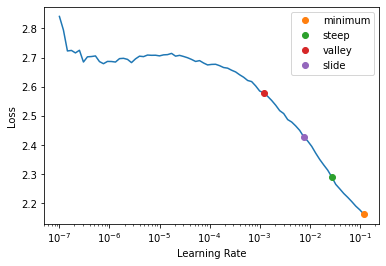

lr: 0.02754228748381138


epoch,train_loss,valid_loss,accuracy,time
0,1.586989,1.257908,0.603556,01:47


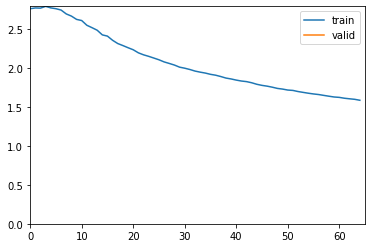

epoch,train_loss,valid_loss,accuracy,time
0,1.229635,nan,0.652571,02:06
1,0.945016,nan,0.780394,02:08
2,0.691208,nan,0.851033,02:05
3,0.509711,nan,0.872657,02:09


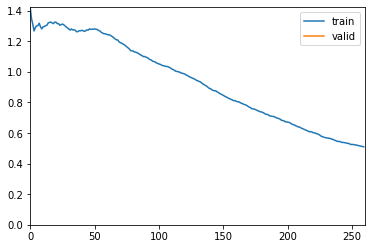

with_relu = False
Convnext: facebook/convnext-tiny-224
Model Weight: 0.47246766090393066

Levit: levit_256
Model Weight: 0.13807351887226105



LR Minimum: 0.014454397559165954
LR Steep: 0.033113110810518265
LR Valley: 0.0014454397605732083
LR Slide: 0.009120108559727669


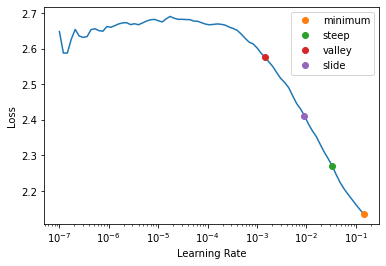

lr: 0.033113110810518265


epoch,train_loss,valid_loss,accuracy,time
0,1.618416,1.224185,0.608842,01:44


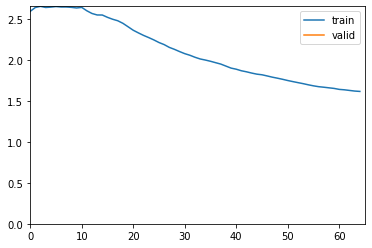

epoch,train_loss,valid_loss,accuracy,time
0,1.210326,nan,0.597309,02:03
1,0.960188,0.774290,0.758770,02:12
2,0.708052,0.463667,0.859202,02:07
3,0.521273,0.430884,0.876021,02:08


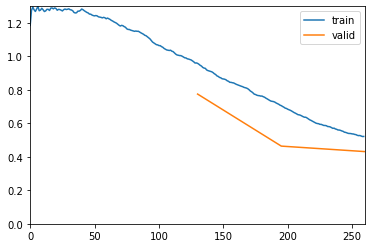

with_relu = True
Convnext: facebook/convnext-tiny-224
Model Weight: 0.6182833313941956

Levit: levit_256
Model Weight: 0.11687936633825302



In [9]:
train_with_relu(MyHFImageModel2, hf_splitter2)

LR Minimum: 0.03019951581954956
LR Steep: 0.013182567432522774
LR Valley: 0.0014454397605732083
LR Slide: 0.010964781977236271


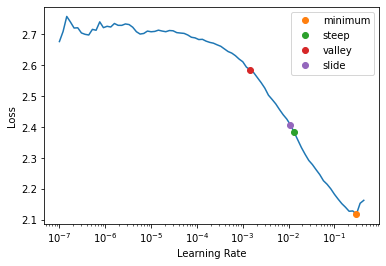

lr: 0.013182567432522774


epoch,train_loss,valid_loss,accuracy,time
0,2.368747,2.059453,0.327727,01:41


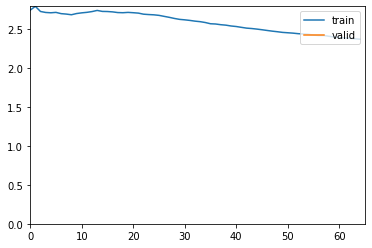

epoch,train_loss,valid_loss,accuracy,time
0,2.122027,1.938596,0.379625,01:41


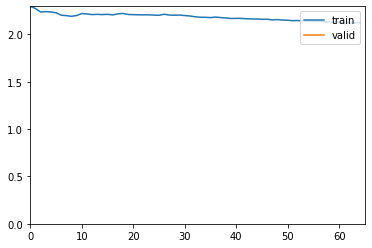

epoch,train_loss,valid_loss,accuracy,time
0,2.040614,1.779327,0.434407,02:04
1,1.909605,1.652256,0.479097,02:06
2,1.849911,1.674650,0.481499,02:04
3,1.816418,1.662918,0.494954,02:02


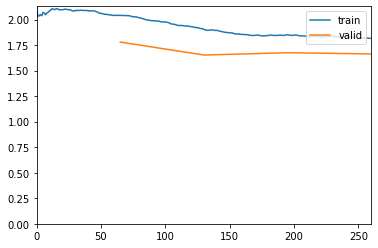

with_relu = False
Convnext: facebook/convnext-tiny-224
Model Weight: 0.5117347240447998

Levit: levit_256
Model Weight: 0.4903790056705475



LR Minimum: 0.012022644281387329
LR Steep: 0.033113110810518265
LR Valley: 0.0008317637839354575
LR Slide: 0.007585775572806597


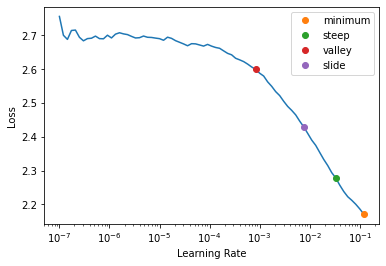

lr: 0.033113110810518265


epoch,train_loss,valid_loss,accuracy,time
0,2.141447,1.830009,0.409419,01:41


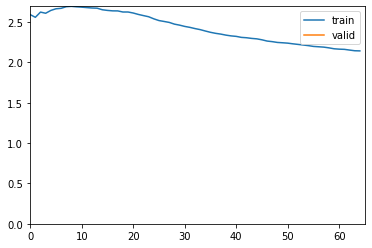

epoch,train_loss,valid_loss,accuracy,time
0,1.866112,1.752374,0.460836,01:44


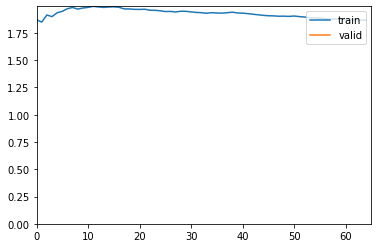

epoch,train_loss,valid_loss,accuracy,time
0,1.796112,1.634475,0.475733,02:05
1,1.685593,1.491909,0.535320,02:10
2,1.610118,nan,0.543008,02:07
3,1.566777,1.503714,0.560308,02:09


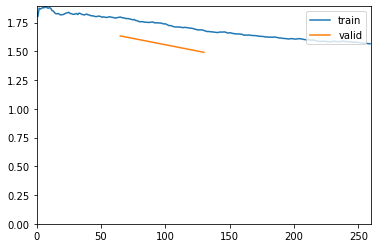

with_relu = True
Convnext: facebook/convnext-tiny-224
Model Weight: 0.5233928561210632

Levit: levit_256
Model Weight: 0.48292452096939087



In [10]:
train_with_relu(MyHFImageModel2, hf_splitter3)

LR Minimum: 0.025118863582611083
LR Steep: 0.015848932787775993
LR Valley: 0.0020892962347716093
LR Slide: 0.009120108559727669


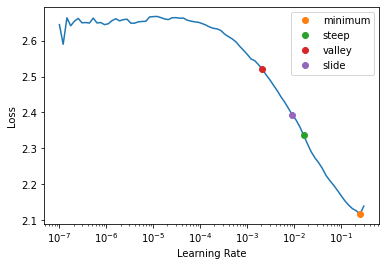

lr: 0.015848932787775993


epoch,train_loss,valid_loss,accuracy,time
0,1.687271,1.270881,0.618453,01:41


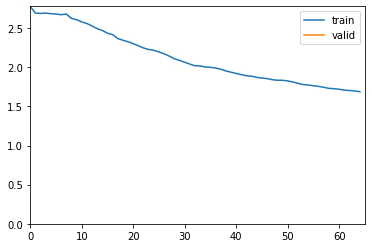

epoch,train_loss,valid_loss,accuracy,time
0,1.282815,0.958160,0.707352,02:06
1,1.068881,nan,0.756367,02:10
2,0.815278,nan,0.833734,02:06
3,0.651537,nan,0.846228,02:10


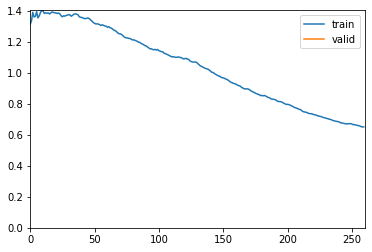

with_relu = False
Convnext: facebook/convnext-tiny-224
Model Weight: 0.5097900032997131

Levit: levit_256
Model Weight: 0.4829264283180237



LR Minimum: 0.012022644281387329
LR Steep: 0.013182567432522774
LR Valley: 0.0005754399462603033
LR Slide: 0.007585775572806597


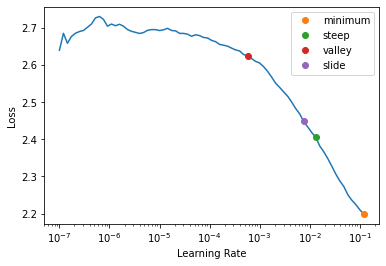

lr: 0.013182567432522774


epoch,train_loss,valid_loss,accuracy,time
0,1.695779,1.190806,0.633349,01:43


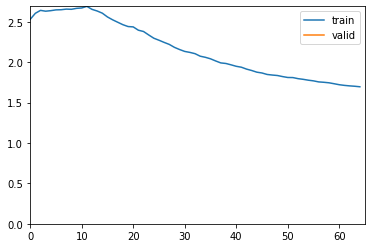

epoch,train_loss,valid_loss,accuracy,time
0,1.301040,1.123981,0.670831,02:05
1,1.099540,nan,0.756848,02:04
2,0.877571,nan,0.819798,02:03
3,0.753304,nan,0.822201,02:04


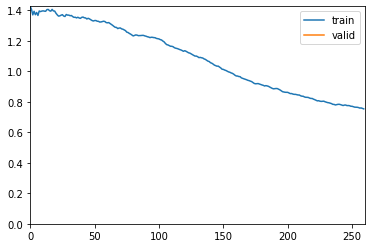

with_relu = True
Convnext: facebook/convnext-tiny-224
Model Weight: 0.5113968253135681

Levit: levit_256
Model Weight: 0.48677513003349304



In [11]:
train_with_relu(MyHFImageModel2, hf_splitter4)

# Let all classes get their own weight
note: I am not expecting a lot here lol 

In [15]:
# Here every class logit gets its own weight parameter

class MyHFImageModel3(MyHFImageModel2):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_weights = nn.Parameter(
            tensor([
                [1.] * len(dls.vocab),
                [1.] * len(dls.vocab),
            ]), 
            requires_grad=True)

lr: 0.0003


epoch,train_loss,valid_loss,accuracy,time
0,2.759974,2.105913,0.375781,01:54


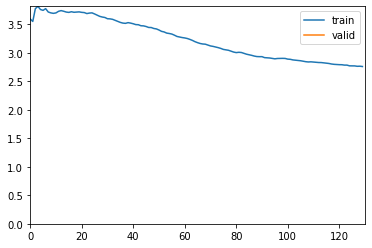

epoch,train_loss,valid_loss,accuracy,time
0,2.284212,nan,0.535800,02:25
1,1.750533,nan,0.664104,02:20
2,1.602812,1.188455,0.643441,02:21
3,1.551063,1.208447,0.646324,02:29


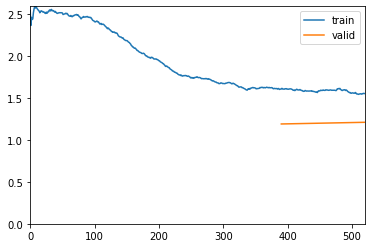

with_relu = False
Convnext: facebook/convnext-tiny-224
Model Weight: [1.0249334573745728, 1.039646029472351, 1.0440906286239624, 1.018377661705017, 1.0227100849151611, 1.0349931716918945, 1.0233265161514282, 1.0214135646820068, 1.026739239692688, 1.027123212814331]

Levit: levit_256
Model Weight: [0.9586821794509888, 0.9610889554023743, 0.9645398259162903, 0.9579749703407288, 0.9581440091133118, 0.9640990495681763, 0.9572947025299072, 0.9555934071540833, 0.9614571332931519, 0.9574894309043884]

lr: 0.0003


epoch,train_loss,valid_loss,accuracy,time
0,2.824426,2.130989,0.375781,01:52


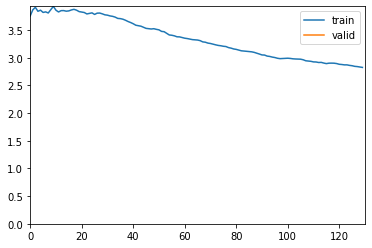

epoch,train_loss,valid_loss,accuracy,time
0,2.402404,nan,0.488707,02:19
1,1.972968,1.551464,0.584815,02:17
2,1.780546,nan,0.613647,02:21
3,1.742203,nan,0.611725,02:27


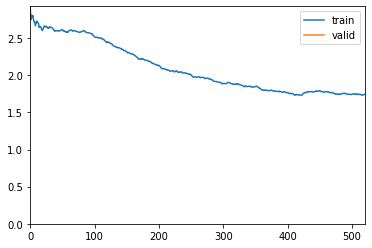

with_relu = True
Convnext: facebook/convnext-tiny-224
Model Weight: [1.0138328075408936, 1.0258718729019165, 1.0272551774978638, 1.0225956439971924, 1.0263909101486206, 1.0364012718200684, 1.0309698581695557, 1.0220303535461426, 1.0258090496063232, 1.0210809707641602]

Levit: levit_256
Model Weight: [0.9602112174034119, 0.9633873105049133, 0.9710214138031006, 0.9577750563621521, 0.9588527083396912, 0.9627177119255066, 0.9602392315864563, 0.9566091895103455, 0.9579532146453857, 0.9574989080429077]



In [16]:
train_with_relu(MyHFImageModel3, hf_splitter2)

# Use a divisor

In [15]:
# Use a divisor

class MyHFImageModel4(MyHFImageModel2):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_weights = nn.Parameter(tensor([1., 1., 2.]), 
                                          requires_grad=True)

    def forward(self, x):
        x = super().forward(x)
        return x / self.model_weights[2]

LR Minimum: 0.03019951581954956
LR Steep: 0.013182567432522774
LR Valley: 0.002511886414140463
LR Slide: 0.004365158267319202


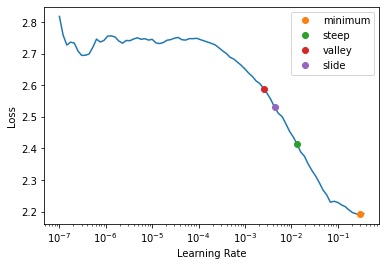

lr: 0.013182567432522774


epoch,train_loss,valid_loss,accuracy,time
0,1.667284,1.276019,0.609322,01:47


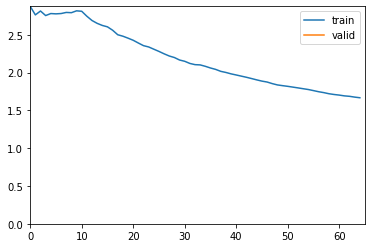

epoch,train_loss,valid_loss,accuracy,time
0,1.239107,nan,0.701586,02:06
1,0.992504,0.740962,0.776069,02:07
2,0.772729,nan,0.829409,02:07
3,0.621536,nan,0.849111,02:06


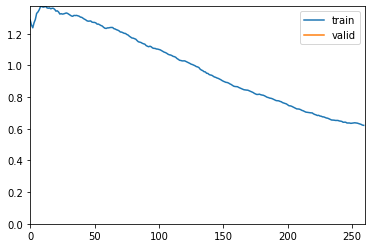

with_relu = False
Convnext: facebook/convnext-tiny-224
Model Weight: 1.2053056955337524

Levit: levit_256
Model Weight: 0.5575438141822815

Divisor: 2.077148914337158



LR Minimum: 0.06309573650360108
LR Steep: 0.02290867641568184
LR Valley: 0.005248074419796467
LR Slide: 0.0063095735386013985


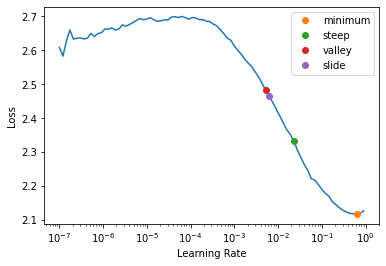

lr: 0.02290867641568184


epoch,train_loss,valid_loss,accuracy,time
0,1.622573,1.307269,0.606920,01:45


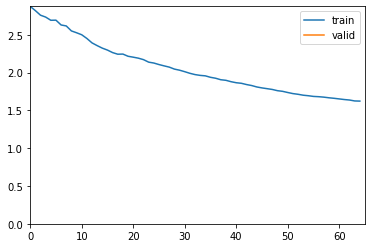

epoch,train_loss,valid_loss,accuracy,time
0,1.224290,nan,0.688611,02:09
1,0.967553,0.710874,0.773186,02:06
2,0.693402,0.555819,0.839020,02:11
3,0.544336,0.468803,0.865930,02:10


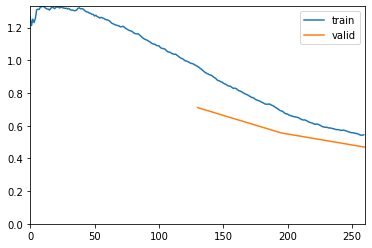

with_relu = True
Convnext: facebook/convnext-tiny-224
Model Weight: 1.4116289615631104

Levit: levit_256
Model Weight: 0.39262816309928894

Divisor: 2.098726749420166



In [16]:
train_with_relu(MyHFImageModel4, hf_splitter2)